# 1% Labeled Semi-supervised image classification using contrastive pretraining with SimCLR

In [1]:
import os
import sys
import math
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-07-27 13:43:25.061975: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Algorithm hyperparameters
num_epochs = 100
image_channels = 3

width = 128 # number of classes that can be detected
temperature = 0.1

seed = 42
val_split   = 0.2
batch_size = 32
image_size = 224

#stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [33]:
test_path = "../Data/OCT2017 /test/"
val_path = "../Data/OCT2017 /val/"
unlab_train_path = "../Data/OCT2017_RAW/train/"

Using test data set as the labeled data set because it contains ~1k images with is ~1% of the entire dataset.
Used 20% of the labeled data for validation set. 
Set the labels as None for the entire dataset to be considered as unlabeled. 

In [6]:
def prepare_dataset():
      
    unlab_train_ds = (tf.keras.utils.image_dataset_from_directory(
        unlab_train_path,
        batch_size=batch_size,
        image_size= (image_size, image_size),
        #seed=seed,
        labels = None
    ))
    
    lab_train_ds = (tf.keras.utils.image_dataset_from_directory(
        test_path,
        batch_size=batch_size,
        image_size=(image_size, image_size),
        seed=seed,
        validation_split=val_split,
        subset='training',
    ))
   
    test_ds = (tf.keras.utils.image_dataset_from_directory(
        test_path,
        batch_size=batch_size,
        image_size=(image_size, image_size),
        seed=seed,
        validation_split=val_split,
        subset='validation',
        ))
    
    train_dataset = tf.data.Dataset.zip((unlab_train_ds, lab_train_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_dataset, lab_train_ds, test_ds


# Load dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

Found 83484 files belonging to 1 classes.
Found 968 files belonging to 4 classes.
Using 775 files for training.
Found 968 files belonging to 4 classes.
Using 193 files for validation.


2022-07-27 13:44:09.417812: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-27 13:44:09.417850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-3-32): /proc/driver/nvidia/version does not exist
2022-07-27 13:44:09.418510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Image Augmentations

In [7]:
images = next(iter(train_dataset))[0][:1]
images.shape

TensorShape([1, 224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


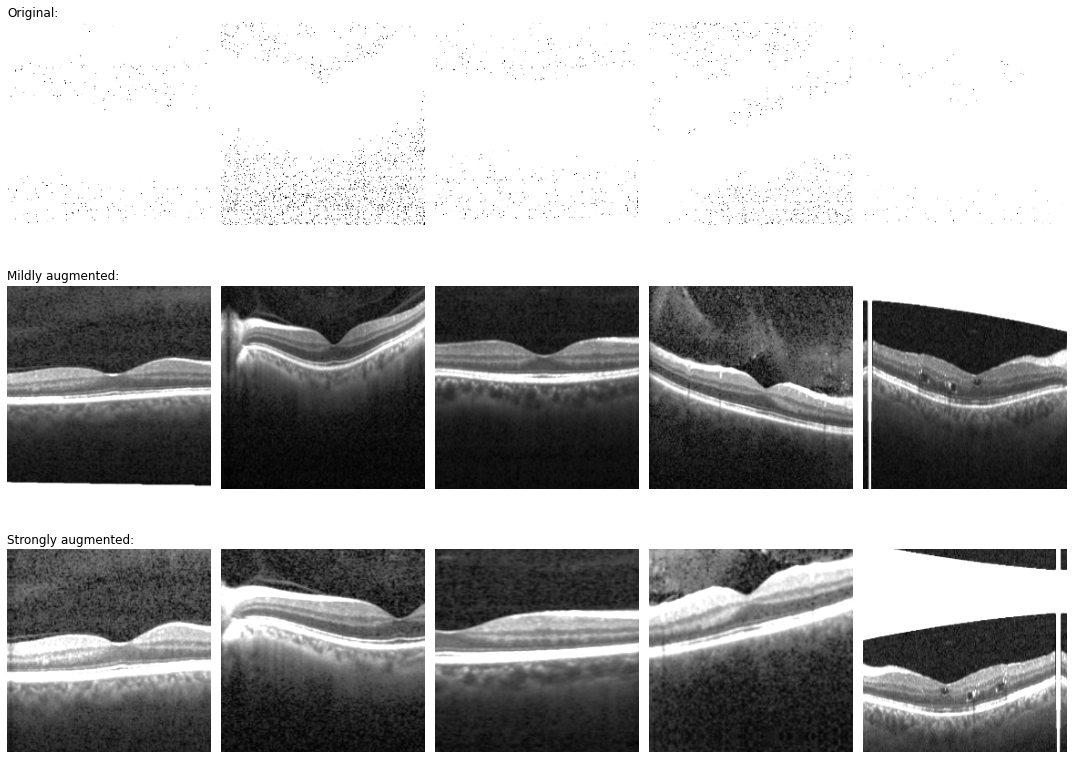

In [8]:
# Distorts the color distributions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter = 0, **kwargs):
        super().__init__(**kwargs)
        
        self.brightness = brightness
        self.jitter = jitter
        
    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config
    
    def call(self, images, training = True):
        if training:
            batch_size = tf.shape(images)[0]
            
            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
            (batch_size, 1,1,1), minval = self.brightness, maxval = self.brightness
            )
            
            # Different for all colors
            jitter_matrices = tf.random.uniform(
            (batch_size, 1, 3, 3), minval = self.jitter, maxval = self.jitter
            )
            
            color_transforms = (
            tf.eye(3, batch_shape = [batch_size, 1]) * brightness_scales + jitter_matrices
            )
            
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images

# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    
    return keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        layers.Rescaling(1 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
        layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
        RandomColorAffine(brightness, jitter)
    ])


def visualize_augmentations(num_images):
    # sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        #get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Mildly augmented:",
        "Strongly augmented:",
        #"Strongly augmented:",
    ]
    plt.figure(figsize = (15,15))
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc = "left")
            plt.axis("off")
    plt.tight_layout()
    
visualize_augmentations(num_images = 5)

### Basemodel Architecture

In [9]:
resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                            weights=None, 
                                            input_shape = (image_size, image_size, image_channels))



def create_basemodel(resnet, 
                     input_shape,
                     dataset,
                     width,
                     n_classes):
    
    image_batch, _ = next(iter(dataset)) # extract 1 batch from the dataset
    feature_batch = resnet(image_batch)
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None)
    base_model.trainable = True
    
    inputs = tf.keras.layers.Input(shape = (image_size, image_size, image_channels))
    pool = tf.keras.layers.GlobalAveragePooling2D()
    relu = tf.keras.layers.Dense(width, activation='relu')
    
    x = inputs
    x = base_model(x)
    x = pool(x)
    out = relu(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

In [10]:
n_classes = 4

create_basemodel(resnet50,(image_size,image_size,image_channels),labeled_train_dataset,width,n_classes).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________


### Supervised baseline model

In [11]:
# Baseline supervised training with random initialization
n_classes = 4

baseline_model = keras.Sequential([
    keras.Input(shape = (image_size, image_size, image_channels)),
    get_augmenter(**classification_augmentation),
    create_basemodel(resnet50, (image_size, image_size, image_channels), labeled_train_dataset, width,n_classes),
    layers.Dense(n_classes)
],name = "baseline_model"
)


metrics = ['accuracy']
callbacks = [#tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', ),
    tf.keras.callbacks.ModelCheckpoint(filepath='../Models/1%_aug_supervised_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
]

optimizer = tf.keras.optimizers.Adam()

baseline_model.compile(
    optimizer = optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = metrics,
)

In [12]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_1 (Functional)        (None, 128)               23849984  
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 23,797,380
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
baseline_history = baseline_model.fit(
    labeled_train_dataset, 
    epochs = num_epochs, 
    validation_data = test_dataset,
    callbacks = callbacks
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/100
25/25 [==============================] - 27s 894ms/step - loss: 2.1805 - accuracy: 0.2284 - val_loss: 1.3858 - val_accuracy: 0.2642
Epoch 2/100
25/25 [==============================] - 21s 833ms/step - loss: 1.4894 - accuracy: 0.2503 - val_loss: 1.3871 - val_accuracy: 0.2539
Epoch 3/100
25/25 [==============================] - 21s 833ms/step - loss: 1.2835 - accuracy: 0.3961 - val_loss: 1.7017 - val_accuracy: 0.2539
Epoch 4/100
25/25 [==============================] - 21s 854ms/step - loss: 1.0265 - accuracy: 0.5394 - val_loss: 1.4756 - val_accuracy: 0.2953
Epoch 5/100
25/25 [==============================] - 21s 833ms/step - loss: 0.8254 - accuracy: 0.6000 - val_loss: 1.4860 - val_accuracy: 0.2487
Epoch 6/100
25/25 [==============================] - 21s 833ms/step - loss: 0.7285 - accuracy: 0.6813 - val_loss: 2.3155 - val_accuracy: 0.2591
Epoch 7/100
25/25 [==============================] - 21s 833ms/step - loss: 0.7722 - accuracy: 0.6723 - val_loss: 2.2693 - val_accuracy:

In [14]:
baseline_model.save("../Models/1%_simclr_supervised_full_070722%.h5")

The baseline model was able to achieve 93.78% accuracy after 100 epochs with 1% labeled dataset. 

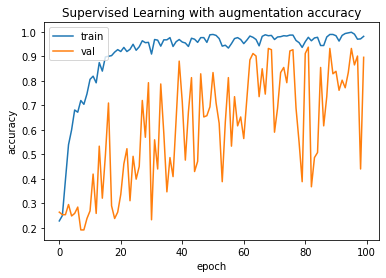

In [15]:
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['val_accuracy'])
plt.title('Supervised Learning with augmentation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
baseline_model.load_weights('../Models/1%_aug_supervised_model.82-0.24.h5')

In [37]:
eval_batch = tf.keras.utils.image_dataset_from_directory(val_path,
                                                         image_size=(image_size, image_size),
                                                         shuffle=False,
                                                         batch_size = 1,
                                                         seed=seed,)

Found 32 files belonging to 4 classes.


In [38]:
baseline_model.evaluate(eval_batch)

32/32 [==============================] - 1s 29ms/step - loss: 0.3765 - accuracy: 0.8750


[0.3764618933200836, 0.875]

Augmented supervised training model achieved **87.5%** accuracy on test set. 

### Self-supervised model for contrastive pretraining

In [16]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder =  create_basemodel(resnet50, (image_size, image_size, image_channels), labeled_train_dataset, width,4)
        # Non-linear MLP as projection head - Note, output is of width width. This is okay as we use matrix calculations to reduce the size to a single loss value per step
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(4)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")
        
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        """These are metrics we want to print and carry through our gradient tape"""
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        unlabeled_images, (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}




In [17]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()#calls the class, which has the inits in it 
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)    

In [21]:
pretraining_history = pretraining_model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset,)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Epoch 1/100
25/25 [==============================] - 67s 3s/step - c_loss: 1.0251 - c_acc: 0.7263 - p_loss: 3.5065 - p_acc: 0.4065 - val_p_loss: 7.2341 - val_p_acc: 0.2383
Epoch 2/100
25/25 [==============================] - 67s 3s/step - c_loss: 0.8805 - c_acc: 0.7616 - p_loss: 5.4491 - p_acc: 0.3806 - val_p_loss: 4.4432 - val_p_acc: 0.3005
Epoch 3/100
25/25 [==============================] - 67s 3s/step - c_loss: 0.8426 - c_acc: 0.7873 - p_loss: 4.8743 - p_acc: 0.4090 - val_p_loss: 3.6359 - val_p_acc: 0.2539
Epoch 4/100
25/25 [==============================] - 67s 3s/step - c_loss: 0.8266 - c_acc: 0.7924 - p_loss: 3.5892 - p_acc: 0.4323 - val_p_loss: 5.8138 - val_p_acc: 0.2850
Epoch 5/100
25/25 [==============================] - 67s 3s/step - c_loss: 0.7407 - c_acc: 0.8057 - p_loss: 3.1909 - p_acc: 0.3871 - val_p_loss: 4.0342 - val_p_acc: 0.2435
Epoch 6/100
25/25 [==============================] - 67s 3s/step - c_loss: 0.7984 - c_acc: 0.8006 - p_loss: 4.4043 - p_acc: 0.3961 - val_p_l

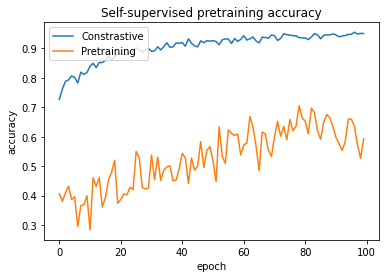

In [22]:
plt.plot(pretraining_history.history['c_acc'])
plt.plot(pretraining_history.history['p_acc'])
plt.title('Self-supervised pretraining accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Constrastive', 'Pretraining'], loc='upper left')
plt.show()

In [22]:
baseline_model.save("../Models/1%_simclr_pretrain_full_46.5%.h5")

Pretraining with accuracy of 46.5% was achieved with 1% labeled data. Low accuracy during pretraining is expected. 

### Supervised finetuning of the pretrained encoder

In [23]:

# Supervised finetuning of the pretrained encoder - Student Net
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(4),
    ],
    name="finetuning_model",
)
#In the above model initiation, we call the pretraining_model.encoder, sharing the trained resnet with the student net
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [27]:
callbacks2 = [tf.keras.callbacks.ModelCheckpoint(filepath='../Models/1%_simclr_semi_supervised_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
]


finetuning_history = finetuning_model.fit(
    labeled_train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset,
    callbacks = callbacks2
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/100
25/25 [==============================] - 22s 864ms/step - loss: 0.1934 - accuracy: 0.9329 - val_loss: 0.7936 - val_accuracy: 0.7668
Epoch 2/100
25/25 [==============================] - 21s 851ms/step - loss: 0.1487 - accuracy: 0.9523 - val_loss: 2.4397 - val_accuracy: 0.5285
Epoch 3/100
25/25 [==============================] - 21s 844ms/step - loss: 0.2740 - accuracy: 0.9032 - val_loss: 1.7504 - val_accuracy: 0.6166
Epoch 4/100
25/25 [==============================] - 22s 867ms/step - loss: 0.1072 - accuracy: 0.9613 - val_loss: 13.2457 - val_accuracy: 0.4249
Epoch 5/100
25/25 [==============================] - 22s 862ms/step - loss: 0.2443 - accuracy: 0.9213 - val_loss: 1.4135 - val_accuracy: 0.6891
Epoch 6/100
25/25 [==============================] - 21s 836ms/step - loss: 0.2210 - accuracy: 0.9342 - val_loss: 3.7161 - val_accuracy: 0.5233
Epoch 7/100
25/25 [==============================] - 21s 860ms/step - loss: 0.1619 - accuracy: 0.9574 - val_loss: 4.2788 - val_accuracy

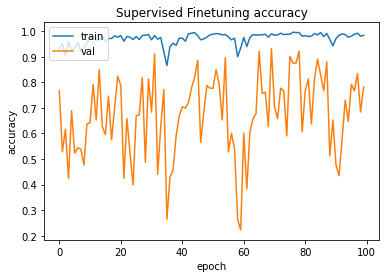

In [28]:
plt.plot(finetuning_history.history['accuracy'])
plt.plot(finetuning_history.history['val_accuracy'])
plt.title('Supervised Finetuning accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
finetuning_model.save("../Models/1%_simclr_semi_supervised_full_93.2%.h5")

93.2% accuracy was achieved after finetuning the supervised model with self-supervised pretrained model.
Next steps: Use 10% dataset with more epochs (200).

In [32]:
finetuning_model.load_weights('../Models/1%_simclr_semi_supervised_full_93.2%.h5')

In [34]:
eval_batch = tf.keras.utils.image_dataset_from_directory(val_path,
                                                         image_size=(image_size, image_size),
                                                         shuffle=False,
                                                         batch_size = 1,
                                                         seed=seed,)

Found 32 files belonging to 4 classes.


In [35]:
finetuning_model.evaluate(eval_batch)

32/32 [==============================] - 1s 30ms/step - loss: 1.2891 - accuracy: 0.8438


[1.2891080379486084, 0.84375]

Semi-supervised model on 1% labeled dataset achieved 84.3% accuracy on the testset. 

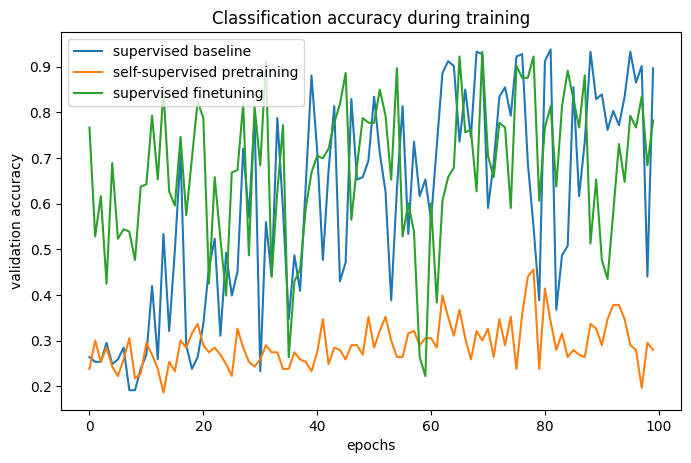

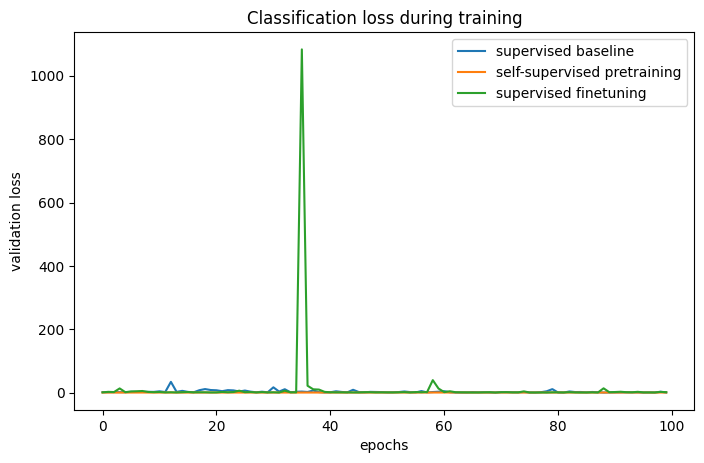

In [39]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["accuracy", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_acc"],

            #pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            #finetuning_history.history[f"val_acc"],
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

# Acknowledgement & Reference

- simCLR model was adapted from [keras.io](https://keras.io/examples/vision/semisupervised_simclr/)